In [2]:
from dataclasses import dataclass
from matplotlib import pyplot as plt

#seaborn : statistical data visualization

import seaborn as sns
import pandas as pd
import numpy as np
from numpy import dtype
from sklearn import metrics, model_selection, preprocessing

import torch
import torch.nn as nn
import torch.utils.data

In [3]:
@dataclass
class Config:
    DATASET = "./dataset_phishing.csv"
    TARGET_COL = "status"
    DEVICE = "cpu"
    EPOCHS = 10
    TRAIN_BS = 1024
    VALID_BS = 1024
    LR = 3e-3

In [4]:
print(Config.DATASET)

./dataset_phishing.csv


In [5]:
class Dataset:
    def __init__(self, data, target) -> None:
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return dict(
            data=torch.tensor(self.data[item], dtype=torch.float),
            target=torch.tensor(self.target[item], dtype=torch.float),
        )

In [6]:
class Model(nn.Module):
    def __init__(self, n_inputs, hidden_units_1, hidden_units_2, n_outputs) -> None:
        super().__init__()
        self.pipeline1 = nn.Sequential(
            nn.Linear(n_inputs, hidden_units_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_1),
            nn.Linear(hidden_units_1, hidden_units_1),
            nn.BatchNorm1d(hidden_units_1),
            nn.Dropout(0.20),
        )
        self.pipeline2 = nn.Sequential(
            nn.Linear(hidden_units_1, hidden_units_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_2),
            nn.Linear(hidden_units_2, hidden_units_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units_2),
            nn.Dropout(0.20),
            nn.Linear(hidden_units_2, hidden_units_1),
        )
        self.output_pipeline = nn.Sequential(nn.Linear(hidden_units_1, n_outputs))

    def forward(self, data):
        out = self.pipeline1(data)
        out = self.pipeline2(out)
        out = self.output_pipeline(out)
        return out

In [7]:
class Engine:
    @staticmethod
    def train(epoch, model, dataset, criterion, optimizer, scheduler):
        model.to(Config.DEVICE)
        model.train()
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.TRAIN_BS)
        losses = 0
        for batch_idx, tdata in enumerate(dataloader):
            data = tdata["data"].to(Config.DEVICE)
            target = tdata["target"].to(Config.DEVICE)
            output = model(data)
            optimizer.zero_grad()
            loss = criterion(output, target.view(-1, 1))
            com_metric = Engine.compute_metrics(output, target.view(-1, 1))
            losses += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            print(
                "[train]: epoch:{0} batch:[{1}/{2}] loss:{3} metrics:{4} ".format(
                    epoch,
                    batch_idx,
                    len(dataloader),
                    (losses / len(dataloader)),
                    com_metric,
                )
            )

    @staticmethod
    def eval(epoch, model, dataset):
        print("---------- * --------------\n")
        model.to(Config.DEVICE)
        model.eval()
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=Config.VALID_BS)
        with torch.no_grad():
            for batch_idx, tdata in enumerate(dataloader):
                data = tdata["data"].to(Config.DEVICE)
                target = tdata["target"].to(Config.DEVICE)
                output = model(data)
                com_metric = Engine.compute_metrics(output, target.view(-1, 1))

                print(
                    "[valid]: epoch:{0} batch:[{1}/{2}] metrics:{3} ".format(
                        epoch,
                        batch_idx,
                        len(dataloader),
                        com_metric,
                    )
                )
            print("---------- * --------------\n")

    @staticmethod
    def generate_predictions(model, dataset, batch_size=1024):
        predictions = []
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        with torch.no_grad():
            model.eval()
            for batch_idx, tdata in enumerate(dataloader):
                data = tdata["data"].to(Config.DEVICE)
                target = tdata["target"].to(Config.DEVICE)
                output = torch.sigmoid(model(data)).detach().cpu().numpy() >= 0.5
                predictions.extend(output)

        return predictions

    @staticmethod
    def compute_metrics(output, target=None):
        if target is None:
            return {}

        device = target.device.type
        output = torch.sigmoid(output).detach().cpu().numpy() >= 0.5
        target = target.detach().cpu().numpy()

        accuracy = metrics.accuracy_score(target, output)
        f1_score = metrics.f1_score(target, output)
        return dict(
            accuracy=torch.tensor(accuracy, device=device, dtype=torch.float32),
            f1_score=torch.tensor(f1_score, device=device, dtype=torch.float32),
        )

cat_cols: ['url', 'status']
                                                     url  length_url  \
0                  http://www.crestonwood.com/router.php          37   
1      http://shadetreetechnology.com/V4/validation/a...          77   
2      https://support-appleld.com.secureupdate.duila...         126   
3                                     http://rgipt.ac.in          18   
4      http://www.iracing.com/tracks/gateway-motorspo...          55   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter          45   
11426  http://www.budgetbots.com/server.php/Server%20...          84   
11427  https://www.facebook.com/Interactive-Televisio...         105   
11428             http://www.mypublicdomainpictures.com/          38   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...         477   

       length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  \
0                   19   0 

[train]: epoch:2 batch:[3/9] loss:0.059748612344264984 metrics:{'accuracy': tensor(0.9561), 'f1_score': tensor(0.9551)} 
[train]: epoch:2 batch:[4/9] loss:0.07564782020118502 metrics:{'accuracy': tensor(0.9551), 'f1_score': tensor(0.9572)} 
[train]: epoch:2 batch:[5/9] loss:0.09338592241207759 metrics:{'accuracy': tensor(0.9375), 'f1_score': tensor(0.9350)} 
[train]: epoch:2 batch:[6/9] loss:0.10336772518025504 metrics:{'accuracy': tensor(0.9717), 'f1_score': tensor(0.9719)} 
[train]: epoch:2 batch:[7/9] loss:0.11643793433904648 metrics:{'accuracy': tensor(0.9580), 'f1_score': tensor(0.9580)} 
[train]: epoch:2 batch:[8/9] loss:0.12658513171805275 metrics:{'accuracy': tensor(0.9748), 'f1_score': tensor(0.9742)} 
---------- * --------------

[valid]: epoch:2 batch:[0/3] metrics:{'accuracy': tensor(0.9473), 'f1_score': tensor(0.9448)} 
[valid]: epoch:2 batch:[1/3] metrics:{'accuracy': tensor(0.9297), 'f1_score': tensor(0.9276)} 
[valid]: epoch:2 batch:[2/3] metrics:{'accuracy': tensor(0.9

[train]: epoch:8 batch:[3/9] loss:0.02377500467830234 metrics:{'accuracy': tensor(0.9834), 'f1_score': tensor(0.9832)} 
[train]: epoch:8 batch:[4/9] loss:0.031405395103825465 metrics:{'accuracy': tensor(0.9814), 'f1_score': tensor(0.9823)} 
[train]: epoch:8 batch:[5/9] loss:0.03721835381454892 metrics:{'accuracy': tensor(0.9814), 'f1_score': tensor(0.9801)} 
[train]: epoch:8 batch:[6/9] loss:0.04187846349345313 metrics:{'accuracy': tensor(0.9834), 'f1_score': tensor(0.9834)} 
[train]: epoch:8 batch:[7/9] loss:0.04850593499011464 metrics:{'accuracy': tensor(0.9775), 'f1_score': tensor(0.9775)} 
[train]: epoch:8 batch:[8/9] loss:0.05292298893133799 metrics:{'accuracy': tensor(0.9863), 'f1_score': tensor(0.9861)} 
---------- * --------------

[valid]: epoch:8 batch:[0/3] metrics:{'accuracy': tensor(0.9609), 'f1_score': tensor(0.9608)} 
[valid]: epoch:8 batch:[1/3] metrics:{'accuracy': tensor(0.9512), 'f1_score': tensor(0.9519)} 
[valid]: epoch:8 batch:[2/3] metrics:{'accuracy': tensor(0.9

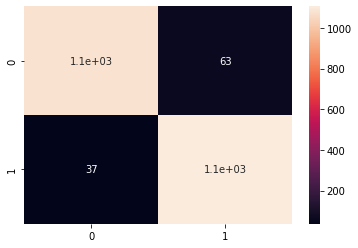

In [8]:
# if __name__ == "__main__":
    
#     torch.manual_seed(12)
#     np.random.seed(12)

    
#     dfx = pd.read_csv(Config.DATASET)
#     cat_cols = [col for col in dfx.columns if dfx[col].dtype == "object"]
#     print("cat_cols:", cat_cols)
#     dfx["target"] = preprocessing.LabelEncoder().fit_transform(dfx[Config.TARGET_COL])
#     print(dfx)
#     print(dfx[[*cat_cols, "target"]].sample(5))
#     df = dfx.drop(["url", "status", "random_domain", "domain_age"], axis=1)

#     # corr = df.corr()
#     # plt.imshow(corr, cmap="viridis", interpolation="nearest")
#     # plt.colorbar()
#     # plt.show()

#     data = preprocessing.MinMaxScaler().fit_transform(
#         df.drop(["target"], axis=1).values
#     )
#     print(data.shape)
#     targets = df["target"].values

#     xtrain, xtest, ytrain, ytest = model_selection.train_test_split(
#         data, targets, test_size=0.20, random_state=0, stratify=df["target"]
#     )
#     print(
#         dict(
#             xtrain_shape=xtrain.shape,
#             xtest_shape=xtest.shape,
#         )
#     )

#     train_dataset = Dataset(xtrain, ytrain)
#     valid_dataset = Dataset(xtest, ytest)

#     model = Model(
#         n_inputs=data.shape[1], hidden_units_1=300, hidden_units_2=100, n_outputs=1
#     )
#     print(model)

#     optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
#     schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.78, gamma=0.3)
#     criterion = nn.BCEWithLogitsLoss()

#     for epoch in range(Config.EPOCHS):
#         Engine.train(
#             epoch=epoch,
#             model=model,
#             dataset=train_dataset,
#             criterion=criterion,
#             optimizer=optimizer,
#             scheduler=schduler,
#         )
#         Engine.eval(epoch=epoch, model=model, dataset=valid_dataset)
#         torch.save(model.state_dict(), "model.pth")
#         #         torch.save(model, "model.bin")

#     predictions = Engine.generate_predictions(model=model, dataset=valid_dataset)
#     confus_mat = metrics.confusion_matrix(ytest, predictions)
#     sns.heatmap(confus_mat, annot=True)
#     plt.show()

In [9]:
import torch
weight = torch.load("model.pth")
model = Model(
    n_inputs=85, hidden_units_1=300, hidden_units_2=100, n_outputs=1
)
model.load_state_dict(weight)

from feature_extractor import extract_features

f = extract_features("https://www.kaggle.com/code/akashkr/phishing-url-eda-and-modelling/notebook","1234")
print(len(f))
print(f)
inputs = torch.Tensor(f).view(1, -1)

model.eval()
with torch.no_grad():
    p = model(inputs)
print(p)
output = torch.sigmoid(p).detach().cpu().numpy() 
print(output)

85
[75, 14, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 10, 6, 3, 3, 3, 9, 6, 9, 5.4, 4.5, 5.625, 0, 0, 0, 0, 0, 0, 39, 0.4358974358974359, 0.5641025641025641, 0.0, 2, 0.0, 0.2727272727272727, 0.0, 0.2727272727272727, 0, 1, 42.10526315789473, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, -1]
tensor([[181.3380]])
[[1.]]
